## Run this top cell to download and extract the flowers data

In [240]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the seed for random number generation so my results are reproducible
np.random.seed(42069)

In [241]:
# Import the oxford_flowers102 dataset
dataset, datasetInfo = tfds.load('oxford_flowers102', with_info=True, split='train')

# Print the dataset info
print(datasetInfo)


tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
    in the United Kingdom. Each class consists of between 40 and 258 images. The images have
    large scale, pose and light variations. In addition, there are categories that have large
    variations within the category and several very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set.
    The training set and validation set each consist of 10 images per class (totalling 1020 images each).
    The test set consists of the remaining 6149 images (minimum 20 per class).
    
    Note: The dataset by default comes with a test size larger than the train
    size. For more info see this [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    data

The image sizes vary a lot, so we'll resize them to 224x224 pixels

In [242]:
# Print the first 5 images in the dataset
for i, example in enumerate(dataset.take(5)):
		print(example['image'].shape)
		print(example['label'])

(500, 667, 3)
tf.Tensor(72, shape=(), dtype=int64)
(500, 666, 3)
tf.Tensor(84, shape=(), dtype=int64)
(670, 500, 3)
tf.Tensor(70, shape=(), dtype=int64)
(500, 505, 3)
tf.Tensor(51, shape=(), dtype=int64)
(500, 672, 3)
tf.Tensor(48, shape=(), dtype=int64)


In [243]:
# Resize the images to 224x224
def resizeImage(image):
	image['image'] = tf.image.resize(image['image'], [224, 224])
	image['image'] = tf.cast(image['image'], dtype = tf.float32)
	return image

# Resize the images
dataset = dataset.map(resizeImage)


In [244]:
train_data = dataset.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [245]:
for i, example in enumerate(train_data.take(5)):
		print(example['image'].shape)
		print(example['label'])

(32, 224, 224, 3)
tf.Tensor(
[ 71  95   0  15  78  68  64  71  14  86  58  60  33 101   2  35  21  50
  97  78  90  90  57  40  20  34  22  55  65  48  26  50], shape=(32,), dtype=int64)
(32, 224, 224, 3)
tf.Tensor(
[100  78  67 100   7  12  42  16  80  26  31  50  75  36 101  45  94  21
  44  91  83  58  68  22  42  57  95  73  97  98  12   2], shape=(32,), dtype=int64)
(32, 224, 224, 3)
tf.Tensor(
[ 4 34 68 88 71 41 35  0 42 72 66 70 84 72 70 55 17 47 38 34 12 12 42 36
 51 24 59 14  6 69 85  4], shape=(32,), dtype=int64)
(32, 224, 224, 3)
tf.Tensor(
[27 89 62 64 34 63 97 61 98 66 20  8  2 21 80 25 47 39 29 30 73 70 69 84
 64 65 72 74 89 96 99 76], shape=(32,), dtype=int64)
(32, 224, 224, 3)
tf.Tensor(
[ 99  62  71  78  60   9  89  92 100  87  26  33  51  36  78  11  38  83
  93  18  39  96  13  82  77  22  83  23  98  67   0  77], shape=(32,), dtype=int64)


In [250]:
# Split the dataset into training and validation sets
train_ds = train_data.take(int(datasetInfo.splits['train'].num_examples * 0.8))
test_ds = train_data.skip(int(datasetInfo.splits['train'].num_examples * 0.8))

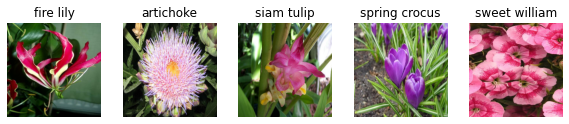

In [253]:
# Show the first 5 images in the training set
plt.figure(figsize=(10, 10))
for i, example in enumerate(train_ds.take(5)):
		image = example['image']
		label = example['label']

		plt.subplot(5, 5, i + 1)
		plt.imshow(image[0] / 255.0)
		plt.title(datasetInfo.features['label'].int2str(label[0]))
		plt.axis('off')

In [254]:
MobileNetV3Small = keras.applications.MobileNetV3Small(
	input_shape=(224, 224, 3),
	include_top=False, 
	weights='imagenet')

# Create the model

model = keras.Sequential()

for layer in MobileNetV3Small.layers[:-10]:
	layer.trainable = False

model.add(MobileNetV3Small)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(102, activation='softmax'))
model.summary()


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 flatten_17 (Flatten)        (None, 28224)             0         
                                                                 
 dense_49 (Dense)            (None, 512)               14451200  
                                                                 
 dropout_32 (Dropout)        (None, 512)               0         
                                                                 
 dense_50 (Dense)            (None, 512)               262656    
                                                                 
 dropout_33 (Dropout)        (None, 512)               0         
                                                     

In [255]:
# Compile the model

model.compile(
	optimizer=keras.optimizers.Adam(learning_rate=0.001),
	metrics=['accuracy'],
	loss='binary_crossentropy',
)

# Train the model
history = model.fit(
	train_ds,
	epochs=20,
)


Epoch 1/20


ValueError: in user code:

    File "c:\Users\mlg\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\input_spec.py", line 197, in assert_input_compatibility
        raise ValueError(

    ValueError: Missing data for input "MobilenetV3small_input". You passed a data dictionary with keys ['file_name', 'image', 'label']. Expected the following keys: ['MobilenetV3small_input']


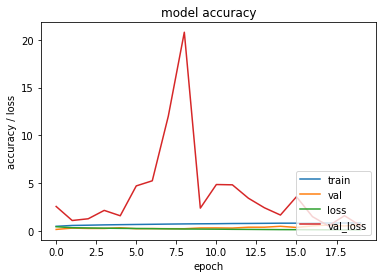

In [ ]:
# Show the model history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy / loss')
plt.xlabel('epoch')
plt.legend(['train', 'val', 'loss', 'val_loss'], loc='lower right')
plt.show()

In [ ]:
# Make all of the model layers trainable
for layer in model.layers:
	layer.trainable = True

model.compile(optimizer=keras.optimizers.Adam(0.000001),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
history = model.fit(
  train_ds,
  epochs=20,
  steps_per_epoch=len(train_ds),
  validation_data=test_ds,
)

Epoch 1/20


c:\Users\mlg\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


850/850 [==============================] - 202s 232ms/step - loss: 0.3189 - accuracy: 0.6876 - val_loss: 0.3040 - val_accuracy: 0.7006
Epoch 2/20
850/850 [==============================] - 187s 220ms/step - loss: 0.3104 - accuracy: 0.6985 - val_loss: 0.2972 - val_accuracy: 0.7104
Epoch 3/20
850/850 [==============================] - 189s 222ms/step - loss: 0.2998 - accuracy: 0.7092 - val_loss: 0.2900 - val_accuracy: 0.7188
Epoch 4/20
850/850 [==============================] - 188s 221ms/step - loss: 0.2921 - accuracy: 0.7189 - val_loss: 0.2825 - val_accuracy: 0.7287
Epoch 5/20
850/850 [==============================] - 188s 221ms/step - loss: 0.2841 - accuracy: 0.7345 - val_loss: 0.2795 - val_accuracy: 0.7344
Epoch 6/20
850/850 [==============================] - 188s 221ms/step - loss: 0.2765 - accuracy: 0.7421 - val_loss: 0.2707 - val_accuracy: 0.7429
Epoch 7/20
850/850 [==============================] - 192s 226ms/step - loss: 0.2691 - accuracy: 0.7511 - val_loss: 0.2641 - val_accura

KeyboardInterrupt: 

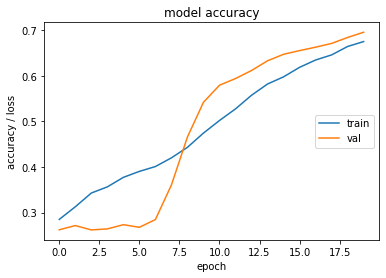

In [ ]:
# Show the model history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
"""plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])"""
plt.title('model accuracy')
plt.ylabel('accuracy / loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center right')#, 'loss', 'val_loss'
plt.show()

In [ ]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 flatten_17 (Flatten)        (None, 47040)             0         
                                                                 
 dense_48 (Dense)            (None, 512)               24084992  
                                                                 
 dropout_31 (Dropout)        (None, 512)               0         
                                                                 
 dense_49 (Dense)            (None, 512)               262656    
                                                                 
 dropout_32 (Dropout)        (None, 512)               0         
                                                     

In [ ]:
# Save the model
model.save('./model-v3Large')

INFO:tensorflow:Assets written to: ./model-v3Large\assets


INFO:tensorflow:Assets written to: ./model-v3Large\assets


1/1 [==============================] - 0s 24ms/step


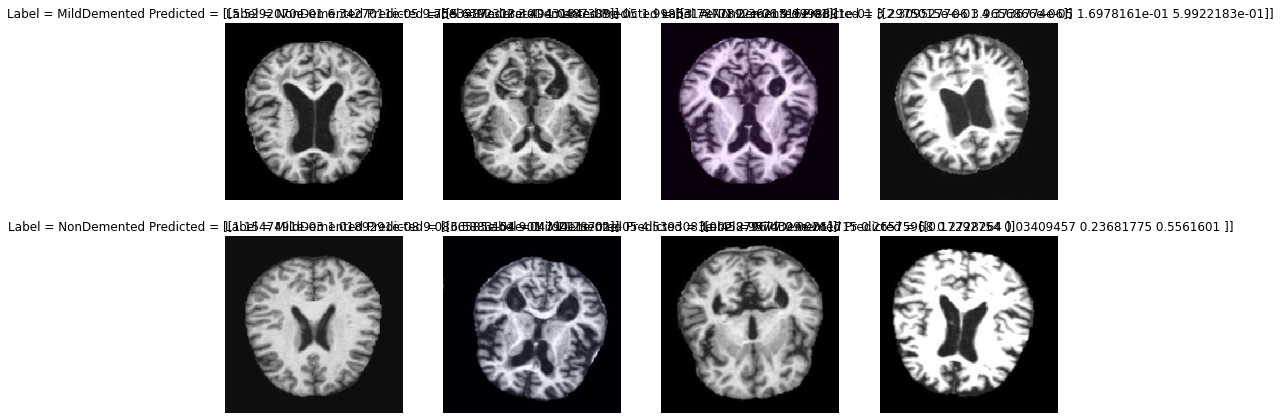

In [ ]:
# Check the accuracy across the 4 classes

plt.figure(figsize=(15, 15))
batch = train_ds.next()
for i in range(0, 8):
    image = batch[0][i]
    plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    labelIndex = list(batch[1][i]).index(1)
    # get the corresponding label from the train_ds.class_indices
    labels = list(train_ds.class_indices.keys())
    label = labels[labelIndex]
    predicted = model.predict(image.reshape(1,224,224,3))
    plt.title("Label = " + label + " Predicted = " + str(predicted))
    plt.axis('off')



In [ ]:
# Create a new model from scratch

"""model = keras.Sequential([
	keras.layers.Conv2D(32, 3, activation='relu', input_shape=(256, 256, 3)),
	keras.layers.MaxPooling2D(),
	keras.layers.Conv2D(64, 3, activation='relu'),
	keras.layers.MaxPooling2D(),
	keras.layers.Flatten(),
	keras.layers.Dense(128, activation='relu'),
	keras.layers.Dense(1, activation='sigmoid')
])"""
"""
# Resize the test and train image data
test_ds_scaled = test_ds.map(lambda x, y: (tf.image.resize(x, (224, 224)), y))
train_ds_scaled = train_ds.map(lambda x, y: (tf.image.resize(x, (224, 224)), y))

model = tf.keras.models.Sequential([
    keras.layers.Conv2D(16, (3,3), activation = 'relu', input_shape = (224,224, 3)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(32, (3,3), activation = 'relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(32, (3,3), activation = 'relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(32, (3,3), activation = 'relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation = 'relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation = 'softmax')
])
model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])
history = model.fit(train_ds_scaled,
    validation_data=test_ds_scaled,
    epochs=10)"""

"\n# Resize the test and train image data\ntest_ds_scaled = test_ds.map(lambda x, y: (tf.image.resize(x, (224, 224)), y))\ntrain_ds_scaled = train_ds.map(lambda x, y: (tf.image.resize(x, (224, 224)), y))\n\nmodel = tf.keras.models.Sequential([\n    keras.layers.Conv2D(16, (3,3), activation = 'relu', input_shape = (224,224, 3)),\n    keras.layers.MaxPooling2D(2,2),\n    keras.layers.Conv2D(32, (3,3), activation = 'relu'),\n    keras.layers.MaxPooling2D(2,2),\n    keras.layers.Conv2D(32, (3,3), activation = 'relu'),\n    keras.layers.MaxPooling2D(2,2),\n    keras.layers.Conv2D(32, (3,3), activation = 'relu'),\n    keras.layers.MaxPooling2D(2,2),\n    keras.layers.Flatten(),\n    keras.layers.Dense(512, activation = 'relu'),\n    keras.layers.Dropout(0.2),\n    keras.layers.Dense(1, activation = 'softmax')\n])\nmodel.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])\nhistory = model.fit(train_ds_scaled,\n    validation_data=test_ds_